In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
sns.set(rc={'figure.figsize':(24, 12)})

In [11]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, roc_auc_score, \
classification_report
from sklearn.ensemble import RandomForestClassifier
import scipy

### Формирование и подготовка данных к обработке и обучению

In [3]:
numeric_cols = ['Amp3', 'Vel3_ms', 'Amp4','Vel4_ms','Amp5','Vel5_ms','Amp6','Vel6_ms',
                'Amp7','Vel7_ms','Amp8','Vel8_ms', 'Thickness']

In [8]:
features = pd.read_excel('parameters.xlsx', sheet_name='w1500')

In [9]:
X = features[numeric_cols]
y = features['defect']

In [12]:
# Масштабирование признаков
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state = 0)

## ForestClassifier

In [14]:
rfc = RandomForestClassifier(n_estimators=100)

In [15]:
params_grid_rfc = {'criterion': ['entropy', 'gini'], 'max_depth':[2, 4, 8, 10]}
cv = 2

In [16]:
optimizer_rfc = GridSearchCV(rfc, params_grid_rfc, cv=cv)

In [17]:
# Обучение модели
optimizer_rfc.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [2, 4, 8, 10]})

In [18]:
optimizer_rfc.best_estimator_

RandomForestClassifier(max_depth=10)

In [19]:
cross_val_score(optimizer_rfc, X_train, y_train, cv=cv).mean()

0.8663884192730347

In [82]:
cross_val_score(optimizer_rfc, X_test, y_test, cv=5).mean()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: Deprecation

0.7850877192982456

In [20]:
y_tree_pred = optimizer_rfc.predict(X_test)

## LogisticRegression

In [21]:
def plot_scores(optimizer):
    scores=[]
    for i in range(len(optimizer.cv_results_['params'])):
        scores.append([optimizer.cv_results_['params'][i]['C'],
                      optimizer.cv_results_['mean_test_score'][i],
                      optimizer.cv_results_['std_test_score'][i]])
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2],
                     scores[:,1]+scores[:,2], alpha=0.3)
    plt.title('label')
    plt.show()

In [22]:
params_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100, 1000]}
cv = 5

In [23]:
estimator = LR()
optimizer = GridSearchCV(estimator, params_grid, scoring = 'accuracy', cv=cv)

In [24]:
optimizer.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 100, 1000]},
             scoring='accuracy')

In [25]:
print(y_test[:10])
print(optimizer.predict(X_test)[:10])

124    0
54     1
268    0
293    0
230    1
134    0
12     0
423    1
272    0
76     1
Name: defect, dtype: int64
[0 1 0 0 0 0 0 1 0 1]


In [26]:
roc_auc = roc_auc_score(y_test, optimizer.predict_proba(X_test)[:,1])
print(roc_auc)

0.8898412698412699


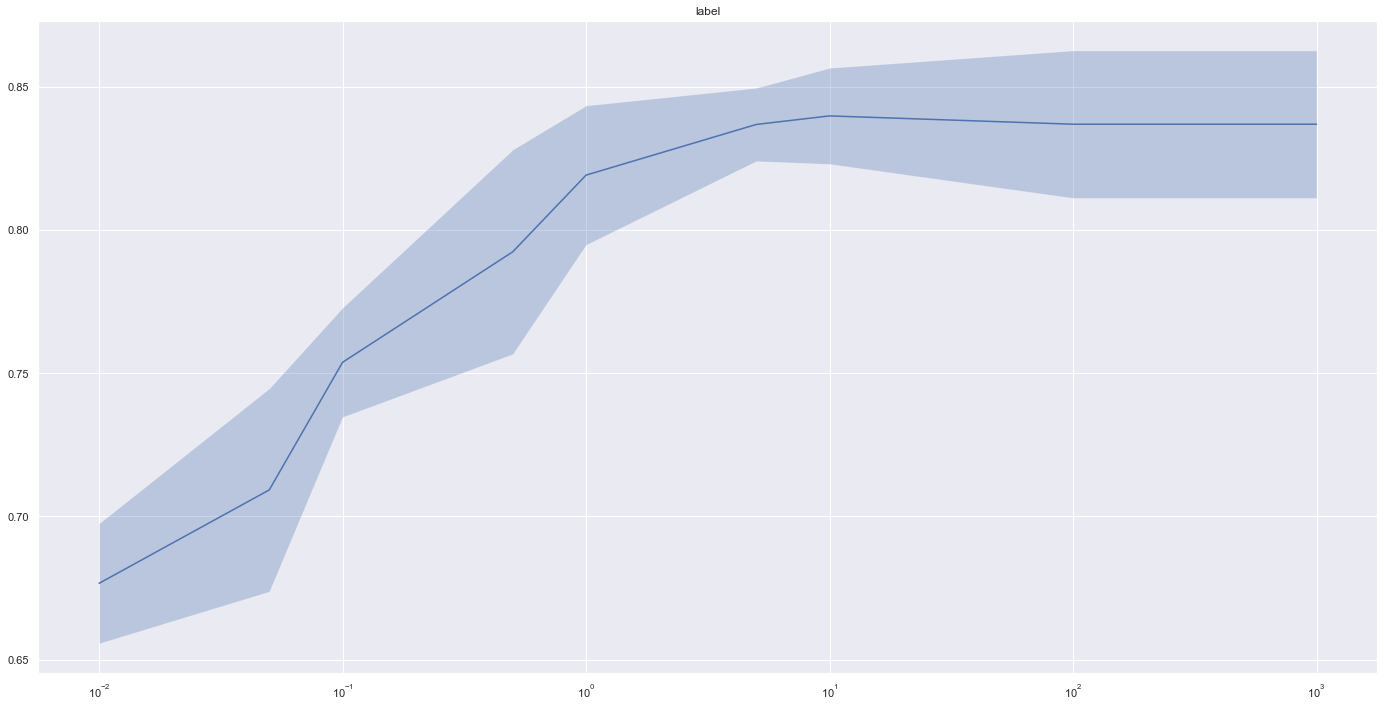

In [27]:
plot_scores(optimizer)

In [28]:
optimizer.best_estimator_.coef_

array([[-0.22146922, -3.68772391, -1.0455588 ,  2.33717019,  0.01031642,
        -0.05012771, -0.52461824,  4.31658489,  0.94572042, -1.2304868 ,
         0.28995691,  0.62346531,  2.6724914 ]])

In [29]:
optimizer.best_estimator_

LogisticRegression(C=10)

In [30]:
cross_val_score(optimizer, X_train, y_train, cv=cv).mean()

0.8398156277436346

In [31]:
y_pred = optimizer.predict(X_test)

## NeuralNetwork

In [40]:
import tensorflow as tf
import tensorflow_datasets as tfds

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [38]:
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

In [41]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [42]:
l0 = tf.keras.layers.Dense(units=4, input_shape=[13,])
l1 = tf.keras.layers.Dense(units=4, activation=tf.nn.relu)
l2 = tf.keras.layers.Dense(units=1, activation=tf.nn.relu)
l3 = tf.keras.layers.Dropout(0)
model1 = tf.keras.Sequential([l0, l1, l2, l3])
model1.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))

In [43]:
hist = model1.fit(X_train, y_train, epochs = 30, verbose=False)
print('End of fit')

End of fit


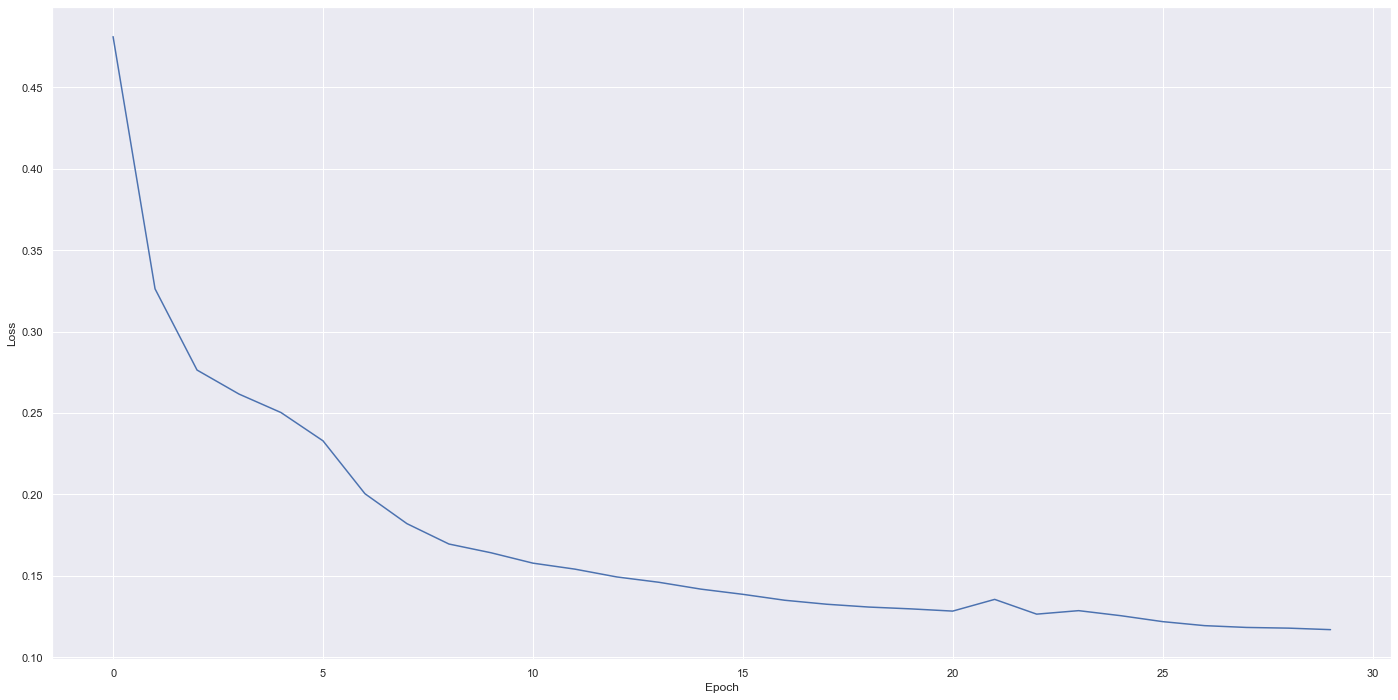

In [44]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(hist.history['loss'])

In [54]:
y_nn_pred = model1.predict(X_test)

In [58]:
# Определяем граничное значение и создаем список, который выведет классификацию после обучения
y_nn_pr = []
for i in range(len(y_nn_pred)):
    if y_nn_pred[i] > 0.5:
        y_nn_pr.append(1)
    else:
        y_nn_pr.append(0)

In [60]:
y_nn_pr = np.array(y_nn_pr)

## CompareResults

In [62]:
print(accuracy_score(y_test, y_tree_pred))
print(accuracy_score(y_test, y_pred))
print(accuracy_score(y_test, y_nn_pr))

0.9380530973451328
0.8230088495575221
0.8584070796460177


In [63]:
print(precision_score(y_test, y_tree_pred))
print(precision_score(y_test, y_pred))
print(precision_score(y_test, y_nn_pr))

0.9574468085106383
0.8947368421052632
0.925


In [64]:
print(recall_score(y_test, y_tree_pred))
print(recall_score(y_test, y_pred))
print(recall_score(y_test, y_nn_pr))

0.9
0.68
0.74


In [65]:
# Метрики логистической регрессии
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86        63
           1       0.89      0.68      0.77        50

    accuracy                           0.82       113
   macro avg       0.84      0.81      0.81       113
weighted avg       0.83      0.82      0.82       113



In [66]:
# Метрики дерева решений
print(classification_report(y_test, y_tree_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        63
           1       0.96      0.90      0.93        50

    accuracy                           0.94       113
   macro avg       0.94      0.93      0.94       113
weighted avg       0.94      0.94      0.94       113



In [67]:
# Метрики нейронной сети
print(classification_report(y_test, y_nn_pr))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88        63
           1       0.93      0.74      0.82        50

    accuracy                           0.86       113
   macro avg       0.87      0.85      0.85       113
weighted avg       0.87      0.86      0.86       113



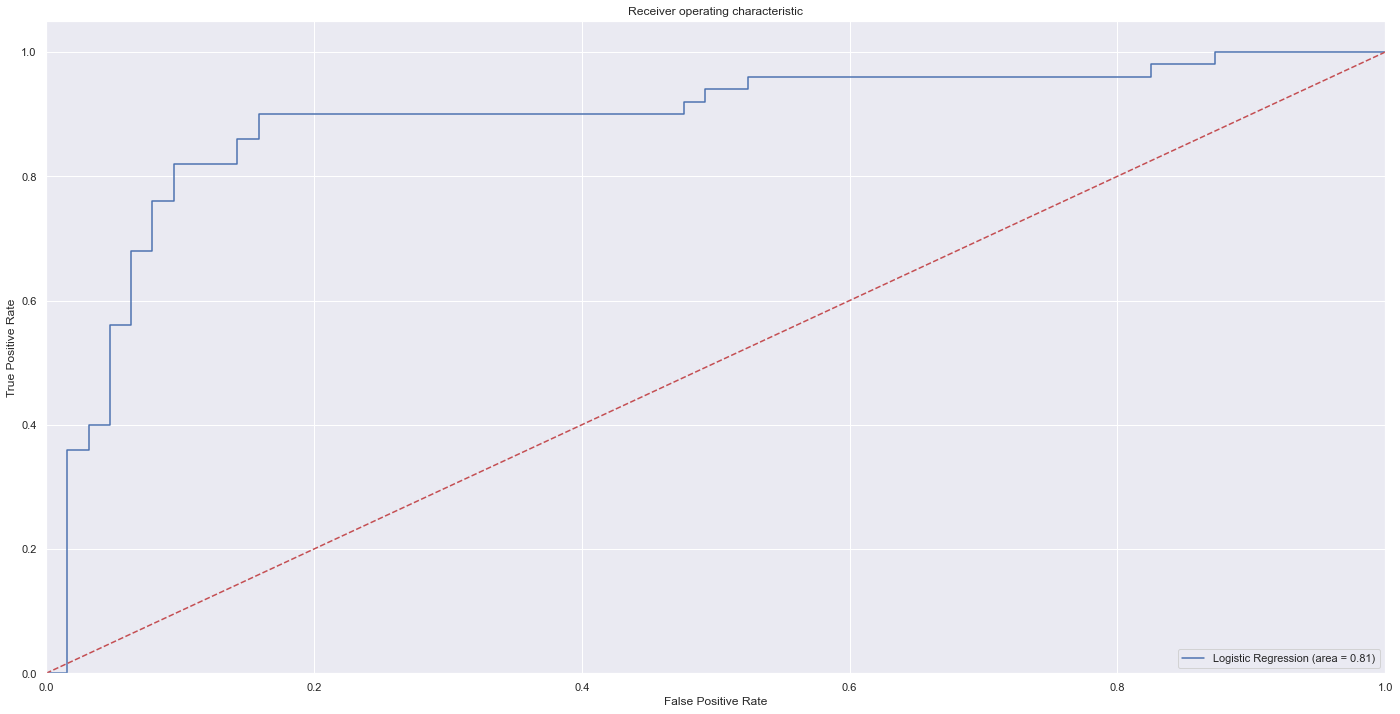

In [68]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, optimizer.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, optimizer.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC_LR')
plt.show()

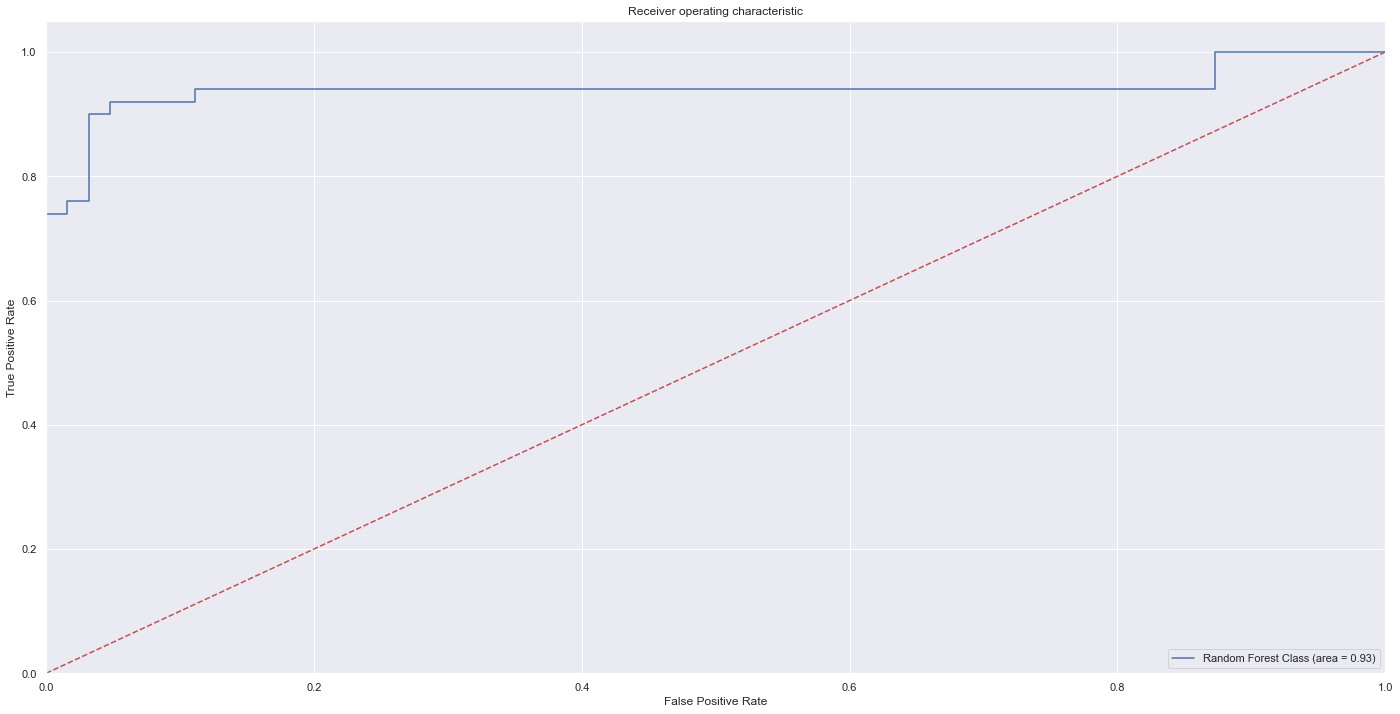

In [69]:
logit_roc_auc = roc_auc_score(y_test, optimizer_rfc.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, optimizer_rfc.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest Class (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC_RFC')
plt.show()

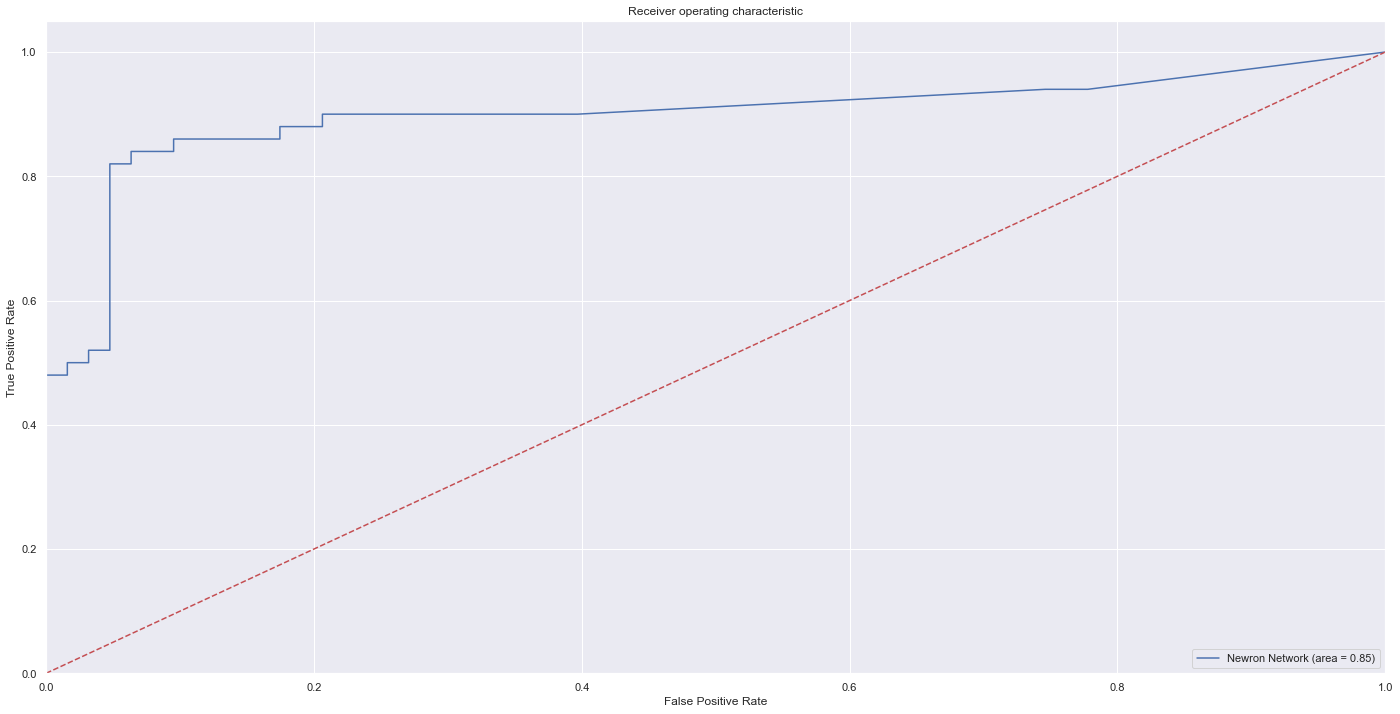

In [70]:
logit_roc_auc = roc_auc_score(y_test, y_nn_pr)
fpr, tpr, thresholds = roc_curve(y_test, y_nn_pred)
plt.figure()
plt.plot(fpr, tpr, label='Newron Network (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC_NN')
plt.show()

## Serialization
### Для внедрения успешной модели в продакшн производим сериализацию

In [71]:
import pickle

In [72]:
model = optimizer_rfc
with open('model', 'wb') as file1:
    pickle.dump(model, file1)

In [73]:
sc = scale.fit(X)
with open('scale', 'wb') as file2:
    pickle.dump(sc, file2)